
## Traffic Sign Recognition Classifier


---
## Step 1: Load The Data
Dataset used : German Traffic Sign Recognition
We load the pickled traffic signs data to unpickle it for processing. 

In [2]:
import pickle

def load_traffic_sign_data(training_file, testing_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return train, test

train, test = load_traffic_sign_data('traffic_signs_data/train.p', 'traffic_signs_data/test.p')
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 2: Dataset Summary & Exploration

The pickled data used for the train, validation, and test datasets is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images.
- `'labels'` is a 2D array containing the label/class id of the traffic sign. We refer to the *signnames.csv* which contains id -> name of each trafiic sign.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

Python and numpy methods to calculate the data summary:

In [3]:
import numpy as np

# The size of the training set and test set
n_train, n_test = X_train.shape[0], X_test.shape[0]

# shape of a traffic sign image (pickled data contains resized data)
image_shape = X_train[0].shape

# distinct classes and labels there are in the dataset:
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples  =", n_test)
print("Image data shape  =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples  = 12630
Image data shape  = (32, 32, 3)
Number of classes = 43


#### Visualizing the German Traffic Signs Dataset using the pickled file(s).

(Visualizing some images sampled from training set:)

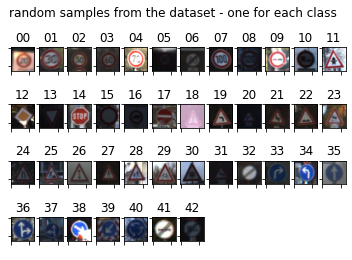

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# show a random sample from each class of the traffic sign dataset
rows, cols = 4, 12
fig, ele_array = plt.subplots(rows, cols)
plt.suptitle('random samples from the dataset - one for each class')
for ind, ele in enumerate(ele_array.ravel()):
    if ind < n_classes:
        cur_X = X_train[y_train == ind]
        cur_img = cur_X[np.random.randint(len(cur_X))] #shows a random image of the current class
        ele.imshow(cur_img)
        ele.set_title('{:02d}'.format(ind))
    else:
        ele.axis('off')
        
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ele_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ele_array.ravel()], visible=False)
plt.draw()

idea of how these classes are distributed in both training and testing set

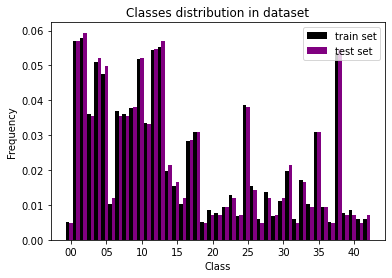

In [11]:
# bar-chart of classes distribution
train_distribution, test_distribution = np.zeros(n_classes), np.zeros(n_classes)
for c in range(n_classes):
    train_distribution[c] = np.sum(y_train == c) / n_train
    test_distribution[c] = np.sum(y_test == c) / n_test
fig, ax = plt.subplots()
col_width = 0.5
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=col_width, color='black')
bar_test = ax.bar(np.arange(n_classes)+col_width, test_distribution, width=col_width, color='purple')
ax.set_ylabel('Frequency')
ax.set_xlabel('Class')
ax.set_title('Classes distribution in dataset')
ax.set_xticks(np.arange(0, n_classes, 5)+col_width)
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend(('train set', 'test set'), loc ="upper right", )
plt.show()

Conclusion: There is a significant class disproportion. While certain classes are significantly underrepresented, others are far more prevalent. The data distribution between the training set and the testing set is, however, nearly identical.

----

## Step 3: Design and Test a Model Architecture

*Objective : To design and put into practise a deep learning model that can recognise traffic signs. The German Traffic Sign Dataset is used to train and test the model.*

Based off of the paper, [[Sermanet, LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) the following data preprosesing methods were employed:

1) Each image is converted from RGB to YUV color space, then only the Y channel is used (grayscale). Color is not an important feature here as we will be able to distinguish the signs wuthout color too. 

2) Histogram equalisation is used to alter each image's contrast. This is done to lessen the many instances where the visual contrast is really poor.

3) Each image is centered on zero mean and divided for its standard deviation. (normalisation) 

**Feature preprocessing**

In [6]:
import cv2 

def preprocess_features(X, equalize_hist=True):

    # convert from RGB to YUV
    X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])

    # adjust image contrast
    if equalize_hist:
        X = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in X])

    X = np.float32(X)

    # standardize features
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)

    return X

X_train_norm = preprocess_features(X_train)
X_test_norm = preprocess_features(X_test)

Using TensorFlow backend.


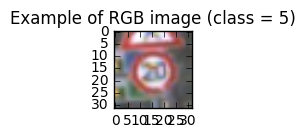

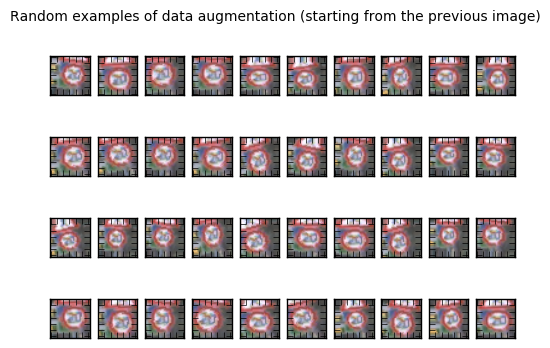

In [7]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# split into train and validation
VAL_RATIO = 0.2
X_train_norm, X_val_norm, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=VAL_RATIO, random_state=0)


# create the generator to perform online data augmentation
image_datagen = ImageDataGenerator(rotation_range=15.,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)


img_rgb = X_train[0]

plt.figure(figsize=(1,1))
plt.imshow(img_rgb)
plt.title('Example of RGB image (class = {})'.format(y_train[0]))
plt.show()


rows, cols = 4, 10
fig, ax_array = plt.subplots(rows, cols)
for ax in ax_array.ravel():
    augmented_img, _ = image_datagen.flow(np.expand_dims(img_rgb, 0), y_train[0:1]).next()
    ax.imshow(np.uint8(np.squeeze(augmented_img)))
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.suptitle('Random examples of data augmentation (starting from the previous image)')
plt.show()

To get *additional data* to gaurd against overfitting, we leverage on the *ImageDataGenerator* class provided in the Keras library. To add some variety to the data without totally changing the original feature content, training images are randomly rotated, zoomed, and rotated, but only within a small range.

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def weight_variable(shape, mu=0, sigma=0.1):
    initialization = tf.truncated_normal(shape=shape, mean=mu, stddev=sigma)
    return tf.Variable(initialization)


def bias_variable(shape, start_val=0.1):
    initialization = tf.constant(start_val, shape=shape)
    return tf.Variable(initialization)


def conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(input=x, filter=W, strides=strides, padding=padding)


def max_pool_2x2(x):
    return tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# network architecture definition
def my_net(x, n_classes):

    c1_out = 64
    conv1_W = weight_variable(shape=(3, 3, 1, c1_out))
    conv1_b = bias_variable(shape=(c1_out,))+
    conv1 = tf.nn.relu(conv2d(x, conv1_W) + conv1_b)

    pool1 = max_pool_2x2(conv1)

    drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob)

    c2_out = 128
    conv2_W = weight_variable(shape=(3, 3, c1_out, c2_out))
    conv2_b = bias_variable(shape=(c2_out,))
    conv2 = tf.nn.relu(conv2d(drop1, conv2_W) + conv2_b)

    pool2 = max_pool_2x2(conv2)

    drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob)

    fc0 = tf.concat(1, [flatten(drop1), flatten(drop2)])

    fc1_out = 64
    fc1_W = weight_variable(shape=(fc0._shape[1].value, fc1_out))
    fc1_b = bias_variable(shape=(fc1_out,))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    drop_fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    fc2_out = n_classes
    fc2_W = weight_variable(shape=(drop_fc1._shape[1].value, fc2_out))
    fc2_b = bias_variable(shape=(fc2_out,))
    logits = tf.matmul(drop_fc1, fc2_W) + fc2_b

    return logits


# placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(dtype=tf.int32, shape=None)
keep_prob = tf.placeholder(tf.float32)


# training pipeline
lr = 0.001
logits = my_net(x, n_classes=n_classes)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss=loss_function)

The final architecture is a relatively shallow network made by 4 layers. The first two layers are convolutional, while the third and last are fully connected. The output of both the first and second convolutional layers are concatenated and fed to the following dense layer. In this way we provide the fully-connected layer visual patterns at both different levels of abstraction. The last fully-connected layer then maps the prediction into one of the 43 classes.


For the training  *Adam optimizer* was used, the adam optimizer adjusts the learning rate throughout training. *Batchsize* was set to 128 due to memory constraints. Every 5000 batches visited, an evaluation on both training and validation set is performed. In order to avoid overfitting, max_pool, data augmentation and dropout (with drop probability of 0.5) are employed extensively.

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    
    num_examples = X_data.shape[0]
    total_accuracy = 0
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCHSIZE):
        batch_x, batch_y = X_data[offset:offset+BATCHSIZE], y_data[offset:offset+BATCHSIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += accuracy * len(batch_x)
        
    return total_accuracy / num_examples

# create a checkpointer to log the weights during training
checkpointer = tf.train.Saver()

In [11]:
# training hyperparameters
BATCHSIZE = 128
EPOCHS = 30
BATCHES_PER_EPOCH = 5000

In [8]:
# start training
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for epoch in range(EPOCHS):

        print("EPOCH {} ...".format(epoch + 1))

        batch_counter = 0
        for batch_x, batch_y in image_datagen.flow(X_train_norm, y_train, batch_size=BATCHSIZE):

            batch_counter += 1
            sess.run(train_step, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            if batch_counter == BATCHES_PER_EPOCH:
                break

        # evaluating accuracy
        train_accuracy = evaluate(X_train_norm, y_train)
        val_accuracy = evaluate(X_val_norm, y_val)
        print('Train Accuracy = {:.3f} - Validation Accuracy: {:.3f}'.format(train_accuracy, val_accuracy))
        
        # logging current weights
        checkpointer.save(sess, save_path='../checkpoints/traffic_sign_model.ckpt', global_step=epoch)

EPOCH 1 ...
Train Accuracy = 0.889 - Validation Accuracy: 0.890
EPOCH 2 ...
Train Accuracy = 0.960 - Validation Accuracy: 0.955
EPOCH 3 ...
Train Accuracy = 0.975 - Validation Accuracy: 0.969
EPOCH 4 ...
Train Accuracy = 0.985 - Validation Accuracy: 0.977
EPOCH 5 ...
Train Accuracy = 0.987 - Validation Accuracy: 0.978
EPOCH 6 ...
Train Accuracy = 0.991 - Validation Accuracy: 0.985
EPOCH 7 ...
Train Accuracy = 0.991 - Validation Accuracy: 0.984
EPOCH 8 ...
Train Accuracy = 0.991 - Validation Accuracy: 0.985
EPOCH 9 ...
Train Accuracy = 0.991 - Validation Accuracy: 0.985
EPOCH 10 ...
Train Accuracy = 0.994 - Validation Accuracy: 0.988
EPOCH 11 ...
Train Accuracy = 0.996 - Validation Accuracy: 0.990
EPOCH 12 ...
Train Accuracy = 0.995 - Validation Accuracy: 0.989
EPOCH 13 ...
Train Accuracy = 0.995 - Validation Accuracy: 0.991
EPOCH 14 ...
Train Accuracy = 0.993 - Validation Accuracy: 0.988
EPOCH 15 ...
Train Accuracy = 0.995 - Validation Accuracy: 0.989
EPOCH 16 ...
Train Accuracy = 0.99

Now we can test the model. We load the weights of the epoch with the highest accuracy on validation set, which are the most promising.

In [12]:
# testing the model
with tf.Session() as sess:

    # restore saved session with highest validation accuracy
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-27')
    
    test_accuracy = evaluate(X_test_norm, y_test)
    print('Performance on test set: {:.3f}'.format(test_accuracy))


Performance on test set: 0.953


---

## Step 3: Testing the Model on New Images

We take several pictures of the traffic signs, and run them through the classifier to produce results.

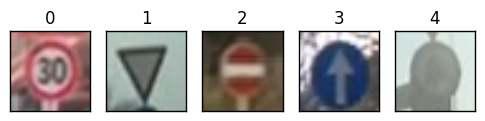

In [43]:
import os

new_images_dir = '../other_signs'
new_test_images = [os.path.join(new_images_dir, f) for f in os.listdir(new_images_dir)]
new_test_images = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in new_test_images]

# manually annotated labels for these new images
new_targets = [1, 13, 17, 35, 40]

# plot new test images
fig, axarray = plt.subplots(1, len(new_test_images))
for i, ax in enumerate(axarray.ravel()):
    ax.imshow(new_test_images[i])
    ax.set_title('{}'.format(i))
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([]), ax.set_yticks([])


The previous five pictures were downloaded from the internet and they're not exactly "clean." For instance, the image contrast in figure 4 ("roundabout obligatory" sign) is so poor that it is hardly feasible to decipher its meaning.

Testing the trained model on these new images: 

In [80]:
#feature preprocessing
new_test_images_norm = preprocess_features(new_test_images)

with tf.Session() as sess:

    # restore saved session
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-27')

    # predict on unseen images
    prediction = np.argmax(np.array(sess.run(logits, feed_dict={x: new_test_images_norm, keep_prob: 1.})), axis=1)

for i, pred in enumerate(prediction):
    print('Image {} - Target = {:02d}, Predicted = {:02d}'.format(i, new_targets[i], pred))
    
print('> Model accuracy: {:.02f}'.format(np.sum(new_targets==prediction)/len(new_targets)))

Image 0 - Target = 01, Predicted = 01
Image 1 - Target = 13, Predicted = 13
Image 2 - Target = 17, Predicted = 02
Image 3 - Target = 35, Predicted = 35
Image 4 - Target = 40, Predicted = 40
> Model accuracy: 0.80


From the signnames.csv we come to understand: <br>
Prediction 01 means *Speed limit (30km/h)* and the prediciton for Image 0 was correct <br>
Prediction 13 means *Yeild* and the prediciton for Image 1 was correct <br>
Prediction 02 means *Speed limit (50km/h)* and since the target and prediciton for Image 2 did not match, prediction was incorrect <br>
Prediction 35 means *Ahead only* and the prediciton for Image 3 was correct <br>
Prediction 40 means *Roundabout mandatoryy* and the prediciton for Image 4 was correct <br>

Hence the model was 80% accurate. 